<a href="https://colab.research.google.com/github/ljbcoder/Project-Tensorflow/blob/main/Project_Tensorflow_AI_from_Scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def sigmoid_derivative(z):
    s = sigmoid(z)
    return s * (1 - s)

def relu(z):
    return np.maximum(0, z)

def relu_derivative(z):
    return (z > 0).astype(float)

def leaky_relu(x, alpha=0.01):
    return np.where(x > 0, x, alpha * x)

def leaky_relu_derivative(x, alpha=0.01):
    return np.where(x > 0, 1, alpha)

#Make sure that softmax function can be used without
def softmax(z):
    exp_z = np.exp(z - np.max(z, axis=0, keepdims=True))
    return exp_z / np.sum(exp_z, axis=0, keepdims=True)

def softmax_derivative(z):
    s = softmax(z)
    return s * (1 - s)


def MSE(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def cross_entropy(y_true, y_pred):
    return -np.sum(y_true * np.log(y_pred))

class ModelLayer:
    def __init__(self, output_size, activation='relu', input_size=None, learning_rate=0.1):
        self.output_size = output_size
        self.input_size = input_size  # Set later if None
        self.activation_name = activation.lower()
        self.learning_rate = learning_rate
        self.activation = None
        self.activation_derivative = None
        self.weights = None  # Will be initialized when input_size is known
        self.bias = None

        self.input_vals = None
        self.z = None

    def build(self, input_size):
        """Initialize weights and biases once input size is known"""
        self.input_size = input_size

        if self.activation_name == 'relu':
            # He initialization
            self.weights = np.random.randn(self.output_size, input_size) * np.sqrt(2. / input_size)
            self.activation = relu
            self.activation_derivative = relu_derivative

        elif self.activation_name == 'leaky_relu':
            # He initialization
            self.weights = np.random.randn(self.output_size, input_size) * np.sqrt(2. / input_size)
            self.activation = leaky_relu
            self.activation_derivative = leaky_relu_derivative

        elif self.activation_name == 'sigmoid':
            # Xavier initialization
            self.weights = np.random.randn(self.output_size, input_size) * np.sqrt(1. / input_size)
            self.activation = sigmoid
            self.activation_derivative = sigmoid_derivative


        else:
            raise ValueError(f"Unsupported activation: {self.activation_name}")

        self.bias = np.zeros((self.output_size, 1))


    def pass_forward(self, input_vals):
        if self.weights is None:
            self.build(input_vals.shape[0])
        self.input_vals = input_vals
        self.z = np.dot(self.weights, input_vals) + self.bias
        return self.activation(self.z)

    def pass_backwards(self, dA):
        dZ = dA * self.activation_derivative(self.z)
        dW = np.dot(dZ, self.input_vals.T)
        dB = dZ
        dA_prev = np.dot(self.weights.T, dZ)

        self.weights -= self.learning_rate * dW
        self.bias -= self.learning_rate * dB

        return dA_prev


class Model:
    def __init__(self):
        self.layers = []
        self.built = False

    def add(self, layer):
        self.layers.append(layer)

    def forward(self, x):
        if not self.built:
            self._build_layers(x.shape[0])
            self.built = True

        for layer in self.layers:
            x = layer.pass_forward(x)
        return x

    def _build_layers(self, input_size):
        for layer in self.layers:
            if layer.input_size is None:
                layer.build(input_size)
            input_size = layer.output_size  # next layer's input

    def backward(self, dLoss):
        for layer in reversed(self.layers):
            dLoss = layer.pass_backwards(dLoss)

    def train(self, x, y_true, epochs=1000, print_every=100):
        for epoch in range(epochs):
            y_pred = self.forward(x)
            loss = np.mean((y_pred - y_true) ** 2)
            dLoss = 2 * (y_pred - y_true)
            self.backward(dLoss)

            if epoch % print_every == 0 or epoch == epochs - 1:
                print(f"Epoch {epoch}, Loss: {loss:.4f}")

    def predict(self, x):
      return self.forward(x)


In [ ]:
def sigmoid(z):
  return 1/(1+np.exp(-z))

def sigmoid_derivative(z):
  s = sigmoid(z)
  return s*(1-s)

def relu(z):
  return np.max(0,z)

def relu_derivative(z):
  return (z>0).astype(float)

def leaky_relu(z,alpha=0.01):
  if z>0:
    return z
  else:
    return alpha*z

def leaky_relu_derivative(x,alpha=0.01):
  return np.where(x>0,1,alpha)

In [ ]:



import numpy as np


model = Model()
model.add(ModelLayer(4, activation='leaky_relu'))


x = np.random.rand(4, 1)
y = np.array([[1], [1], [0], [0]])

model.train(x, y, epochs=100)
model.predict(x)

Epoch 0, Loss: 0.3757
Epoch 99, Loss: 0.0000


array([[ 1.00000000e+00],
       [ 1.00000000e+00],
       [ 5.55111512e-17],
       [-2.33480947e-03]])

In [ ]:
import numpy as np

# Generate 100 house sizes between 500 and 3500 sqft
sqft = np.random.uniform(500, 3500, size=(1, 100))  # shape (1, 100)
price = 200 * sqft + 50000                          # price = 200 * sqft + 50k
price += np.random.randn(1, 100) * 10000            # add some noises


In [ ]:
print(sqft)

[[2980.49861598 1237.73686347 1834.56578602 3382.66469291 3080.4852769
  1183.4930693  3395.29683719 1879.80756321 2822.49843546 1047.35946541
  1308.15349093 1431.65884865 1877.17367375 2907.42946542 3082.95481563
  2748.92033657 1437.35365892 2280.07795001 1816.17470386  681.88729838
  1055.34371559 2212.07004786 1890.03155819  862.72219819 1626.74832708
  1652.47289241 3392.52950772 3391.98972574 2289.90388507 2274.51640772
  2265.47451938  834.71503874 1766.41082394 3438.26816673  688.97024033
  3088.38256311 1915.1392962  2668.27822782 2541.99563777 2324.62082712
  3017.94449106  630.56874837 3378.4010847   953.65738227 3050.51406112
  1037.50239164  609.08768025 2701.88319766 2112.51094664  767.37928316
  2329.17319737 1349.10851325  829.58782146 1983.12104622 3014.62872154
  1520.16643913  763.64246404 1702.98646568 2296.41483737 1786.05642725
  1353.71245486 2210.9949241  1834.77696569 1837.31699784 1624.05955706
  3208.19480668 1042.92163426  659.53200576 2527.6700721  1495.58

In [ ]:
housemodel = Model()
housemodel.add(ModelLayer(1, activation='linear', input_size=1, learning_rate=1e-7))

  # Use low learning rate due to large outputs
housemodel.train(sqft, price, epochs=1000, print_every=100)




TypeError: unsupported operand type(s) for *: 'NoneType' and 'float'

In [ ]:
print(model.layers[0].weights)
print(model.layers[0].bias)

[[-1.78063498 -0.46442502 -0.41676732 -0.03846604]
 [-0.09199558  0.88326973  0.52355762 -1.23248312]
 [ 0.68986584 -0.55300088  0.02077039 -0.06488225]
 [-1.04242472  0.96643341 -0.01569079 -0.53808634]]
[[ 0.        ]
 [-0.08229945]
 [-0.09500813]
 [ 0.        ]]


In [ ]:
from io import BufferedIOBase
import numpy as np

I = np.array([[0.05,.10]])
T = np.array([[0,1]])
WH = np.array([[0.15, 0.25],
               [0.2,0.3]])

BH = np.array([[0.35,0.35]])
WO = np.array([[0.4, 0.5],
               [0.45,0.55]])
BO = np.array([[0.6,.6]])

for epoch in range(100000):
  print(epoch)

  #Apply sigmoid to first layer
  H = I @ WH + BH
  H = 1/(1+np.exp(-H))

  #Apply Softmax for second layer
  O = H @ WO + BO
  OM = O - np.max(O)
  O = np.exp(OM)/np.sum(np.exp(OM))

  E = np.sum(-T*np.log(O))
  if E < 0.0001:
    break

  Ob = O - T
  #Nothing for softmax cross entropy error

  Hb = Ob @ WO.T
  Hb = Hb * H * (1-H)

  WHb = I.T @ Hb
  BHb = 1* Hb
  WOb = H.T @ Ob
  BOb = 1 * Ob

  lr = 0.01
  WH = WH - lr * WHb
  BH = BH - lr * BHb
  WO = WO - lr * WOb
  BO = BO - lr - BOb




FINAL CODE

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [ ]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

# Load data
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize and reshape
x_train = x_train.reshape(-1, 28*28).T / 255.0  # shape: (784, num_samples)
x_test = x_test.reshape(-1, 28*28).T / 255.0

# One-hot encode labels
y_train_encoded = to_categorical(y_train).T  # shape: (10, num_samples)
y_test_encoded = to_categorical(y_test).T


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
y_train_encoded[:,1:5]

array([[1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 1.]])

In [ ]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def sigmoid_derivative(z):
    s = sigmoid(z)
    return s * (1 - s)

def relu(z):
    return np.maximum(0, z)

def relu_derivative(z):
    return (z > 0).astype(float)

def leaky_relu(x, alpha=0.01):
    return np.where(x > 0, x, alpha * x)

def leaky_relu_derivative(x, alpha=0.01):
    return np.where(x > 0, 1, alpha)

def softmax(z):
    exp_z = np.exp(z - np.max(z, axis=0, keepdims=True))
    return exp_z / np.sum(exp_z, axis=0, keepdims=True)

#Softmax derivative is implicit, and handled by cross entropy
# def softmax_derivative(z):
#     s = softmax(z)
#     return s * (1 - s)

#Loss Functions
def MSE(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def MSE_derivative(y_true, y_pred):
    return 2 * (y_pred - y_true)

def cross_entropy(y_true, y_pred):
    epsilon = 1e-15  # Small value to avoid log(0)
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)  # Clip values to avoid log(0)
    return -np.sum(y_true * np.log(y_pred))


def cross_entropy_derivative(y_true, y_pred):
    return y_pred - y_true

class ModelLayer:
    def __init__(self, output_size, activation='relu', input_size=None, learning_rate=0.001):
        self.output_size = output_size
        self.input_size = input_size  # Set later if None
        self.activation_name = activation.lower()
        self.activation = None
        self.activation_derivative = None

        self.learning_rate = learning_rate

        self.weights = None  # Will be initialized when input_size is known
        self.bias = None

        self.input_vals = None
        self.z = None

    def build(self, input_size):
        """Initialize weights and biases once input size is known"""
        self.input_size = input_size

        if self.activation_name == 'relu':
            # He initialization
            self.weights = np.random.randn(self.output_size, input_size) * np.sqrt(2. / input_size)
            self.activation = relu
            self.activation_derivative = relu_derivative

        elif self.activation_name == 'leaky_relu':
            # He initialization
            self.weights = np.random.randn(self.output_size, input_size) * np.sqrt(2. / input_size)
            self.activation = leaky_relu
            self.activation_derivative = leaky_relu_derivative

        elif self.activation_name == 'sigmoid':
            # Xavier initialization
            self.weights = np.random.randn(self.output_size, input_size) * np.sqrt(1. / input_size)
            self.activation = sigmoid
            self.activation_derivative = sigmoid_derivative

        elif self.activation_name == 'softmax':
            # Xavier initialization
            self.weights = np.random.randn(self.output_size, input_size) * np.sqrt(1. / input_size)
            self.activation = softmax
            self.activation_derivative = None
        else:
            raise ValueError(f"Unsupported activation: {self.activation_name}")

        self.bias = np.zeros((self.output_size, 1))


    def pass_forward(self, input_vals):
        if self.weights is None:
            self.build(input_vals.shape[0])
        self.input_vals = input_vals
        self.z = np.dot(self.weights, input_vals) + self.bias
        return self.activation(self.z)

    def pass_backwards(self, dA):
        if self.activation_name == 'softmax':
            dZ = dA  # Softmax derivative handled implicitly --> cross-entropy
        else:
            dZ = dA * self.activation_derivative(self.z)

        dW = np.dot(dZ, self.input_vals.T)
        dB = np.sum(dZ, axis=1, keepdims=True)  # Sum across the batch size for biases (Need for dim)
        dA_prev = np.dot(self.weights.T, dZ)

        self.weights -= self.learning_rate * dW
        self.bias -= self.learning_rate * dB

        return dA_prev



class Model:
    def __init__(self,loss_function,layers = []):
        self.layers = layers
        self.built = False
        self.loss_function_name = loss_function.lower()

        #Apply the loss function
        if self.loss_function_name == 'mse':
          self.loss_function = MSE
          self.loss_function_derivative = MSE_derivative

        elif self.loss_function_name == 'cross_entropy':
          self.loss_function = cross_entropy
          self.loss_function_derivative = cross_entropy_derivative

        else:
          raise ValueError(f"Unsupported activation: {loss_function}")

    def add(self, layer):
        self.layers.append(layer)

    def forward(self, x):
        if not self.built:
            self._build_layers(x.shape[0])
            self.built = True

        for layer in self.layers:
            x = layer.pass_forward(x)
        return x

    def _build_layers(self, input_size):
        for layer in self.layers:
            if layer.input_size is None:
                layer.build(input_size)
            input_size = layer.output_size  # next layer's input

    def backward(self, dLoss):
        for layer in reversed(self.layers):
            dLoss = layer.pass_backwards(dLoss)

    #Change so you can apply batch gradient descent, minibatch, and normal
    def train(self, x, y_true, epochs=20, print_every=1):
        for epoch in range(epochs):
            for start in range(0, len(x[0]), 100):  # Process in batches of 100 samples
                x_batch = x[:, start:start+100]  # Shape: (784, 100)
                y_batch = y_true[:, start:start+100]  # Shape: (10, 100)

                # Forward pass
                y_pred = self.forward(x_batch)  # Shape: (10, 100)

                # Compute the loss for the entire batch
                loss = self.loss_function(y_batch, y_pred)  # Shape: (10, 100)
                dLoss = self.loss_function_derivative(y_batch, y_pred)

                # Backward pass
                self.backward(dLoss)

            if epoch % print_every == 0 or epoch == epochs - 1:
                print(f"Epoch {epoch}, Loss: {loss:.4f}")


    def predict(self, x):
      return self.forward(x)


In [ ]:
model = Model(loss_function = "cross_entropy")
model.add(ModelLayer(128, activation='relu'))
model.add(ModelLayer(64, activation='relu'))
model.add(ModelLayer(32, activation='relu'))
model.add(ModelLayer(10, activation='softmax'))


model.train(x_train[:,:1000], y_train_encoded[:,:1000], epochs=500, print_every=100)

Epoch 0, Loss: 206.6819
Epoch 100, Loss: 0.3837


KeyboardInterrupt: 

In [ ]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def sigmoid_derivative(z):
    s = sigmoid(z)
    return s * (1 - s)

def relu(z):
    return np.maximum(0, z)

def relu_derivative(z):
    return (z > 0).astype(float)

def leaky_relu(x, alpha=0.01):
    return np.where(x > 0, x, alpha * x)

def leaky_relu_derivative(x, alpha=0.01):
    return np.where(x > 0, 1, alpha)

def softmax(z):
    exp_z = np.exp(z - np.max(z, axis=0, keepdims=True))
    return exp_z / np.sum(exp_z, axis=0, keepdims=True)

#Softmax derivative is implicit, and handled by cross entropy
# def softmax_derivative(z):
#     s = softmax(z)
#     return s * (1 - s) --> This eventually cancels out with 1/s multiplied in the backpropagation step

#Loss Functions
def MSE(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def MSE_derivative(y_true, y_pred):
    return 2 * (y_pred - y_true)

def cross_entropy(y_true, y_pred):
    epsilon = 1e-10  # Small value to avoid log(0)
    y_pred = np.clip(y_pred, epsilon, 1. - epsilon)  # Clip values to avoid log(0)
    return -np.sum(y_true * np.log(y_pred))


def cross_entropy_derivative(y_true, y_pred):
    return y_pred - y_true

class ModelLayer:
    def __init__(self, output_size, activation='relu', input_size=None, learning_rate=0.001):
        self.output_size = output_size
        self.input_size = input_size  # Set later if None
        self.activation_name = activation.lower()
        self.activation = None
        self.activation_derivative = None

        self.learning_rate = learning_rate

        self.weights = None  # Will be initialized when input_size is known
        self.bias = None

        self.input_vals = None
        self.z = None

    def build(self, input_size):
        """Initialize weights and biases once input size is known"""
        self.input_size = input_size

        if self.activation_name == 'relu':
            # He initialization
            self.weights = np.random.randn(self.output_size, input_size) * np.sqrt(2. / input_size)
            self.activation = relu
            self.activation_derivative = relu_derivative

        elif self.activation_name == 'leaky_relu':
            # He initialization
            self.weights = np.random.randn(self.output_size, input_size) * np.sqrt(2. / input_size)
            self.activation = leaky_relu
            self.activation_derivative = leaky_relu_derivative

        elif self.activation_name == 'sigmoid':
            # Xavier initialization
            self.weights = np.random.randn(self.output_size, input_size) * np.sqrt(1. / input_size)
            self.activation = sigmoid
            self.activation_derivative = sigmoid_derivative

        elif self.activation_name == 'softmax':
            # Xavier initialization
            self.weights = np.random.randn(self.output_size, input_size) * np.sqrt(1. / input_size)
            self.activation = softmax
            self.activation_derivative = None
        else:
            raise ValueError(f"Unsupported activation: {self.activation_name}")

        self.bias = np.zeros((self.output_size, 1))


    def pass_forward(self, input_vals):
        if self.weights is None:
            self.build(input_vals.shape[0])
        self.input_vals = input_vals
        self.z = np.dot(self.weights, input_vals) + self.bias
        return self.activation(self.z)

    def pass_backwards(self, dA):
        if self.activation_name == 'softmax':
            dZ = dA  # Softmax derivative is handled implicitly in cross-entropy
        else:
          dZ = dA * self.activation_derivative(self.z)

        dW = np.dot(dZ, self.input_vals.T)
        dB = np.sum(dZ, axis=1, keepdims=True)
        dA_prev = np.dot(self.weights.T, dZ)

        self.weights -= self.learning_rate * dW
        self.bias -= self.learning_rate * dB

        return dA_prev

    def reset_weights(self):
        self.build(self.input_size)

class Model:
    def __init__(self,layers = []):
        self.layers = layers
        self.built = False

    def add(self, layer):
        self.layers.append(layer)

    def forward(self, x):
        if not self.built:
            self._build_layers(x.shape[0])
            self.built = True

        for layer in self.layers:
            x = layer.pass_forward(x)
        return x

    def _build_layers(self, input_size):
        for layer in self.layers:
            if layer.input_size is None:
                layer.build(input_size)
            input_size = layer.output_size  # next layer's input

    def compile(self, optimizer, loss_function):
        self.optimizer = optimizer.lower()

        self.loss_function_name = loss_function.lower()

        #Apply the loss function
        if self.loss_function_name == 'mse':
          self.loss_function = MSE
          self.loss_function_derivative = MSE_derivative

        elif self.loss_function_name == 'cross_entropy':
          self.loss_function = cross_entropy
          self.loss_function_derivative = cross_entropy_derivative

        else:
          raise ValueError(f"Unsupported Loss Function: {loss_function}")


    def backward(self, dLoss):
        for layer in reversed(self.layers):
            dLoss = layer.pass_backwards(dLoss)

    def train(self, x, y_true, epochs=20, batch_size = 100, print_every=1):
        if self.optimizer == 'sgd':
            for epoch in range(epochs):
                for start in range(0, len(x[0]), batch_size):  # Process in batches of 100 samples
                    x_batch = x[:, start:start+batch_size]  # Shape: (784, 100)
                    y_batch = y_true[:, start:start+batch_size]  # Shape: (10, 100)

                    # Forward pass
                    y_pred = self.forward(x_batch)  # Shape: (10, 100)

                    # Compute the loss for the entire batch
                    loss = self.loss_function(y_batch, y_pred)  # Shape: (10, 100)
                    dLoss = self.loss_function_derivative(y_batch, y_pred)

                    # Backward pass
                    self.backward(dLoss)

                if epoch % print_every == 0 or epoch == epochs - 1:
                    print(f"Epoch {epoch}, Loss: {loss:.4f}")

        else:
            raise ValueError(f"Unsupported optimizer: {self.optimizer}")

    def reset_weights(self):
        for layer in self.layers:
            layer.reset_weights()

    def predict(self, x):
      return self.forward(x)

    def evaluate(self,x_test, y_test):
        correct = 0
        for i in range(len(x_test[0])):
            current_image = x_test[:, i, None]
            prediction = self.predict(current_image)
            label = y_test[i]
            if np.argmax(prediction) == label:
                correct += 1
        return correct / len(x_test[0]) #Finding the average score of the values




In [ ]:
model = Model()
model.add(ModelLayer(128, activation='relu'))
model.add(ModelLayer(64, activation='relu'))
model.add(ModelLayer(32, activation='relu'))
model.add(ModelLayer(10, activation='softmax'))

model.compile(optimizer="sgd", loss_function="cross_entropy")

# Force layer build by passing in input shape
_ = model.forward(x_train[:, :1])
model.reset_weights()

model.train(x_train[:, :2000], y_train_encoded[:, :2000], epochs=50, print_every=10)


Epoch 0, Loss: 124.3961
Epoch 10, Loss: 11.1877
Epoch 20, Loss: 4.1599
Epoch 30, Loss: 1.8390
Epoch 40, Loss: 0.9485
Epoch 49, Loss: 0.6012


Model Output: 
 [[1.35066060e-10]
 [9.99982961e-01]
 [2.82404498e-08]
 [5.90270649e-08]
 [4.17962946e-06]
 [5.36897510e-07]
 [5.50151986e-08]
 [8.72948886e-06]
 [3.44869935e-06]
 [2.04862295e-09]]
Prediction:  1
Label:  1


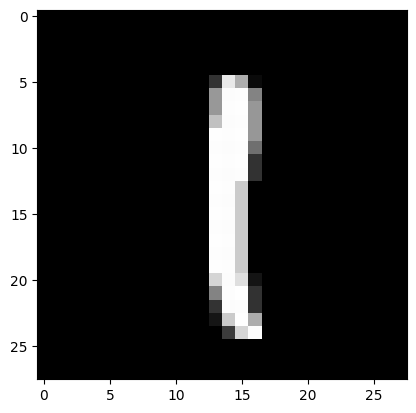

In [ ]:
import random

def test_prediction(index):
    current_image = x_test[:, index, None]
    prediction = model.predict(current_image)
    label = y_test[index]


    print("Model Output: \n", prediction)
    print("Prediction: ", np.argmax(prediction))
    print("Label: ", label)

    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()


test_prediction(random.randint(0,len(x_test)))

In [ ]:
model.evaluate(x_test, y_test)

0.9018

[[3. 1. 1.]
 [1. 1. 3.]
 [1. 3. 1.]]
